In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
from astropy.cosmology import Planck13

In [2]:
import os
from astropy.table import Table
dirname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/prelim_sfh_reduction"
history_fname = "sfh_catalog_1.002310_smcut_9.50_value_added_histories.hdf5"
histories = Table.read(os.path.join(dirname, history_fname), path='data')
cosmic_age_array = np.load(os.path.join(dirname, 'times.npy'))

In [3]:
from read_sfh import get_scales
dirname="/Users/aphearin/Dropbox/UniverseMachine/data/histories"
basename="small_sfh_catalog_1.002310.txt"
tree_fname = os.path.join(dirname, basename)
scale_factor_array = get_scales(tree_fname)
redshift_array = (1./scale_factor_array) - 1
redshift_array[-1] = 0.

## Cross-match to get Vmax at Mpeak

In [9]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck')

from halotools.utils import crossmatch
idxA, idxB = crossmatch(histories['id'], halocat.halo_table['halo_id'])

histories['vmax_at_mpeak'] = 0.
histories['vmax_at_mpeak'][idxA] = halocat.halo_table['halo_vmax_mpeak'][idxB]

### Build a lookup table

In [15]:
from halotools.mock_observables import mean_y_vs_x

log_vmax_table, log_sm_table, __ = mean_y_vs_x(np.log10(histories['vmax_at_mpeak']), 
                                           np.log10(histories['sm']))

## Calculate evolution of main sequence peak for different $M_*$

In [17]:
from main_sequence_sfr import mean_sfr
from sfr_designation import quiescent_fraction

In [35]:
logsm_bins = np.arange(9.5, 11.75, 0.25)
logsm_mids = (logsm_bins[:-1] + logsm_bins[1:])/2.
Vmax_array = 10**np.interp(logsm_mids, log_sm_table, log_vmax_table)

In [39]:
quiescent_fraction_array = np.zeros((len(Vmax_array), len(redshift_array)))

for ibin, Vmax in enumerate(Vmax_array):
    quiescent_fraction_array[ibin, :] = quiescent_fraction(Vmax, redshift=redshift_array)

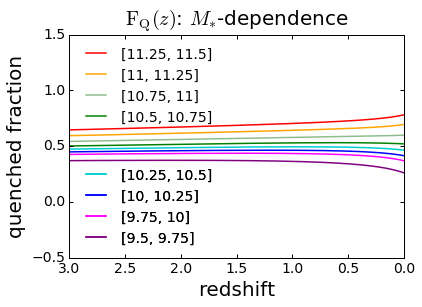

In [61]:
from scipy.signal import savgol_filter

fig1 = plt.figure()
ax = fig1.add_subplot(111)
# ax2 = ax.twiny()

xlabel = ax.set_xlabel('redshift', fontsize=20)
ylabel = ax.set_ylabel(r'quenched fraction', fontsize=20)
title = ax.set_title(r'${\rm F_Q}(z)$: $M_{\ast}$-dependence', fontsize=20, y=1.02) # y param fixes an overhanging title

ifirst=0

lw = 1.5
ax.plot(redshift_array, quiescent_fraction_array[0, :], 
         color='purple', linewidth=lw)
ax.plot(redshift_array, quiescent_fraction_array[1, :], 
         color='magenta', linewidth=lw)
ax.plot(redshift_array, quiescent_fraction_array[2, :], 
         color='blue', linewidth=lw)
ax.plot(redshift_array, quiescent_fraction_array[3, :], 
         color='darkturquoise', linewidth=lw)
ax.plot(redshift_array, quiescent_fraction_array[4, :], 
         color='green', linewidth=lw)
ax.plot(redshift_array, quiescent_fraction_array[5, :], 
         color='darkseagreen', linewidth=lw)
ax.plot(redshift_array, quiescent_fraction_array[6, :], 
         color='orange', linewidth=lw)
ax.plot(redshift_array, quiescent_fraction_array[7, :], 
         color='red', linewidth=lw)


plt.xlim(xmin = 3, xmax=0)
plt.ylim(ymin = -0.5, ymax = 1.5)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.tick_params(axis='x', length=4, width=1, which='major')
ax.tick_params(axis='x', length=2, width=1, which='minor')
ax.tick_params(axis='y', length=4, width=1, which='major')
ax.tick_params(axis='y', length=2, width=1, which='minor')

purple_line = mlines.Line2D([], [], ls = '-', c = 'purple', linewidth=lw, label='[9.5, 9.75]')
magenta_line = mlines.Line2D([], [], ls = '-', c = 'magenta', linewidth=lw, label='[9.75, 10]')
blue_line = mlines.Line2D([], [], ls = '-', c = 'blue', linewidth=lw, label='[10, 10.25]')
darkturquoise_line = mlines.Line2D([], [], ls = '-', c = 'darkturquoise', linewidth=lw, label='[10.25, 10.5]')
green_line = mlines.Line2D([], [], ls = '-', c = 'green', linewidth=lw, label='[10.5, 10.75]')
darkseagreen_line = mlines.Line2D([], [], ls = '-', c = 'darkseagreen', linewidth=lw, label='[10.75, 11]')
orange_line = mlines.Line2D([], [], ls = '-', c = 'orange', linewidth=lw, label='[11, 11.25]')
red_line = mlines.Line2D([], [], ls = '-', c = 'red', linewidth=lw, label='[11.25, 11.5]')

first_legend = plt.legend(handles=[red_line, orange_line, darkseagreen_line, green_line], 
                                frameon=False, loc='upper left', fontsize=14)
ax.add_artist(first_legend)

second_legend = plt.legend(handles=[darkturquoise_line, blue_line, magenta_line, purple_line], 
                                frameon=False, loc='lower left', fontsize=14)
ax.add_artist(second_legend)

fig1.savefig('FIGS/quenched_fraction_history_sm_dependence.pdf', 
             bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')